# Simulate a function

## 采用的模型

| Model                                      | Parameter |
| :----------------------------------------- | :-------: |
| shallow model：  `1->190->1`                      |    571    |
| moddile model：  `1->10->18->15->4->1`            |    572    |
| deep model：     `1->5->10->10->10->10->10->5->1` |    571    |

> 注：上述模型采用Tanh作为激活函数
>
> 拟合函数1：$sin(5\pi x)/5\pi x$
>
> 拟合函数2：$sgn(sin(5\pi x))$
>
> 数据域：$[0,1,0.001]$---总共1000个数
>
> 训练采用的参数：`batch_size=250, optimizer=Adam(lr=1e-3), epoch=2000 `

In [1]:
import sys
sys.path.insert(0, '..')
import os
import torch
import numpy as np
from argparse import Namespace
from torch import optim
from model import mse_loss
from model import deep_simulate, middle_simulate, shallow_simulate
from solver import HW1Solver
from dataset.simulate_data import simulate_dataloader, get_target_func

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# 设置参数 --- 你可以令visdom=True, 然后在http://localhost:8097上看训练过程
config = {'batch_size': 250, 'epochs': 2000, 'resume': '', 'verbosity': 1, 'use_cuda': False, 'lr': 1e-3,
          'save_dir': '../pretrained/1_1_1', 'save_freq': 500, 'save_grad': False, 'log_iter': False,
          'data_dir': '', 'dataset': 'simulate', 'valid': True, 'val_step': 200,
          'visdom': False, 'visdom_iter': False, 'visdom_fit': True}
model_list = ['shallow_simulate', 'middle_simulate', 'deep_simulate']

## 训练拟合$sin(5\pi x)/(5\pi x)$

In [4]:
# 转为argparse相同的形式 --- 为了和本地版本一致
config.update({'target_func': 'sin'})  # 可以选择sin或者ssin两种函数---当然你可以自己在dataset里面加其他函数
config = Namespace(**config)

In [ ]:
# 训练阶段  --- 可能需要花费几分钟, 请耐心等待～
# ---友情提示: 你也可以直接使用提供的已训练好的模型, 那么你就别运行这部分了 ---
for name in model_list:
    model = eval(name)()
    optimizer = optim.Adam(model.parameters(), config.lr)
    loss = mse_loss
    train_loader = simulate_dataloader(config.target_func, config.batch_size)
    val_loader = simulate_dataloader(config.target_func, 1, shuffle=False)
    solver = HW1Solver(model, optimizer, loss, [], train_loader, val_loader, config)
    solver.train()

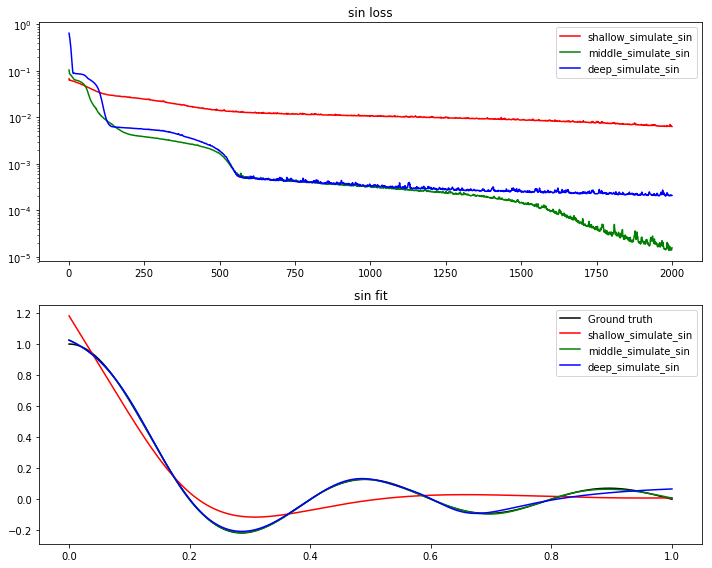

In [5]:
# 可视化结果
color_list = ['r', 'g', 'b']
func = get_target_func(config.target_func)
x = np.array([i for i in np.linspace(1e-10, 1, 1000)])
y_target = np.array([func(i) for i in x])
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1.set_title(config.target_func + ' loss')
ax2.set_title(config.target_func + ' fit')
ax2.plot(x, y_target, 'k', label='Ground truth')
for arch, color in zip(model_list, color_list):
    pre_trained = config.save_dir + '/{}_{}_epoch{:02d}.pth.tar'.format(arch, config.target_func, config.epochs)
    checkpoint = torch.load(pre_trained)
    logger = checkpoint['logger']
    epoch = [entry['epoch'] for _, entry in logger.entries.items()]
    loss = [entry['loss'] for _, entry in logger.entries.items()]
    ax1.semilogy(epoch, loss, color, label=arch + '_' + config.target_func)
    ax1.legend(loc="best")
    model = eval(arch)()
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    y_pred = np.array([model(torch.FloatTensor(np.array([[i]]))).data.numpy() for i in x]).squeeze()
    ax2.plot(x, y_pred, color, label=arch + '_' + config.target_func)
    ax2.legend(loc="best")
plt.tight_layout()

### 结果分析

1. 从上图结果来看：其实反而是Middle模型的结果最好；这部分可能是由于Deep模型并没有很好的收敛
2. 但是Middle模型和Deep模型的效果明显要好于Shallow的情况
3. 说明：①您可以继续多迭代一些轮数看下效果 ②此处采用tanh作为激活函数，或许可以换做其他的激活函数

## 训练拟合$sign(sin(5\pi x))$

In [6]:
# 修改参数
config.target_func = 'ssin'  

In [ ]:
# 训练阶段  --- 可能需要花费几分钟, 请耐心等待～
# ---友情提示: 你也可以直接使用提供的已训练好的模型, 那么你就别运行这部分了 ---
for name in model_list:
    model = eval(name)()
    optimizer = optim.Adam(model.parameters(), config.lr)
    loss = mse_loss
    train_loader = simulate_dataloader(config.target_func, config.batch_size)
    val_loader = simulate_dataloader(config.target_func, 1, shuffle=False)
    solver = HW1Solver(model, optimizer, loss, [], train_loader, val_loader, config)
    solver.train()

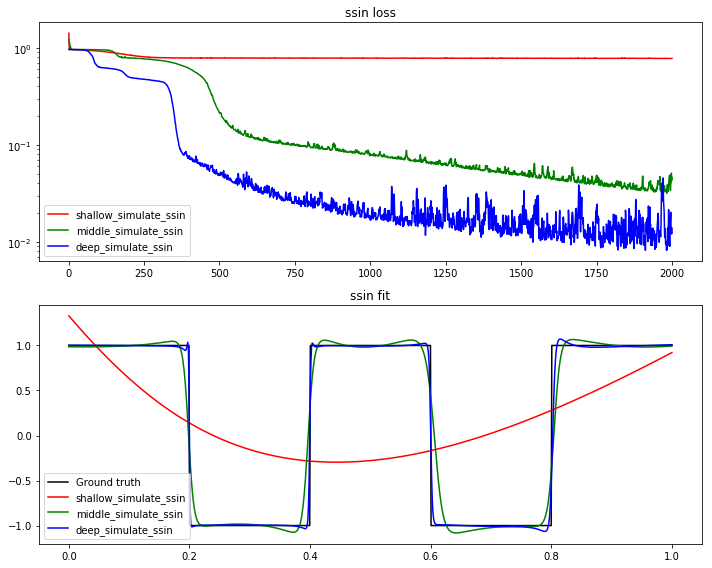

In [7]:
# 可视化结果
func = get_target_func(config.target_func)
x = np.array([i for i in np.linspace(1e-10, 1, 1000)])
y_target = np.array([func(i) for i in x])
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1.set_title(config.target_func + ' loss')
ax2.set_title(config.target_func + ' fit')
ax2.plot(x, y_target, 'k', label='Ground truth')
for arch, color in zip(model_list, color_list):
    pre_trained = config.save_dir + '/{}_{}_epoch{:02d}.pth.tar'.format(arch, config.target_func, config.epochs)
    checkpoint = torch.load(pre_trained)
    logger = checkpoint['logger']
    epoch = [entry['epoch'] for _, entry in logger.entries.items()]
    loss = [entry['loss'] for _, entry in logger.entries.items()]
    ax1.semilogy(epoch, loss, color, label=arch + '_' + config.target_func)
    ax1.legend(loc="best")
    model = eval(arch)()
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    y_pred = np.array([model(torch.FloatTensor(np.array([[i]]))).data.numpy() for i in x]).squeeze()
    ax2.plot(x, y_pred, color, label=arch + '_' + config.target_func)
    ax2.legend(loc="best")
plt.tight_layout()

### 结果分析

1. 可以看到Deep模型相比Middle和Shallow模型收敛更快，拟合效果更快（从侧面可以说明Deep模型在拟合那些"变化"剧烈的情况会更强）
2. 此处从损失来看, Middle模型继续训练下去效果可能也会更好
3. 整体而言该实验能说明Deep的收敛更快，但似乎还不能说明Deep比Middle的性能好（您可以继续多迭代几轮看看）